In [4]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os

os.environ['KAGGLE_USERNAME'] = "abdelrahmankk" # username from the json file
os.environ['KAGGLE_KEY'] = "a30629a68db200820967e40f6a4df4d2"
!kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.004
!kaggle competitions download -c diabetic-retinopathy-detection -f trainLabels.csv.zip

100% 7.81G/7.81G [03:37<00:00, 41.2MB/s]
100% 7.81G/7.81G [03:37<00:00, 38.6MB/s]
100% 69.4k/69.4k [00:00<00:00, 617kB/s]
100% 69.4k/69.4k [00:00<00:00, 615kB/s]


In [6]:
! unzip "trainLabels.csv.zip"
! unzip "train.zip.004.zip"

Archive:  trainLabels.csv.zip
  inflating: trainLabels.csv         
Archive:  train.zip.004.zip
  inflating: train.zip.004           


In [7]:
!apt install p7zip-full -y
!7z x train.zip.004
!ls train | wc -l #print number of images


Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 8388608000 bytes (8000 MiB)

Extracting archive: train.zip.004
  3% 256 Open               9% 768 Open              15% 1280 Open               21% 1792 Open               27% 2304 Open               33% 2816 Open          

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [9]:
base_image_dir = "/content/train"
retina_df = pd.read_csv("/content/trainLabels.csv")
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))
retina_df['level_cat'] = retina_df['level_cat'].astype(str)
retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

8415 images found of 35126 total


,image,level,PatientId,path,exists,eye,level_cat
31665,39988_right,0,39988,/content/train/39988_right.jpeg,True,0,[1. 0. 0. 0. 0.]
584,706_left,0,706,/content/train/706_left.jpeg,True,1,[1. 0. 0. 0. 0.]
31223,39456_right,0,39456,/content/train/39456_right.jpeg,True,0,[1. 0. 0. 0. 0.]


# Examine the distribution of eye and severity

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f4ee79ca0>,
      dtype=object)

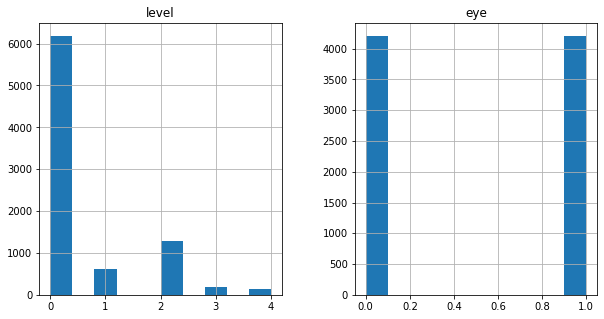

In [10]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

# Split Data into Training and Validation

In [11]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 6511 validation 2310


# Balance the distribution in the training set

New Data Size: 750 Old Size: 6511
0      [1. 0. 0. 0. 0.]
1      [1. 0. 0. 0. 0.]
2      [1. 0. 0. 0. 0.]
3      [1. 0. 0. 0. 0.]
4      [1. 0. 0. 0. 0.]
             ...       
745    [0. 0. 0. 0. 1.]
746    [0. 0. 0. 0. 1.]
747    [0. 0. 0. 0. 1.]
748    [0. 0. 0. 0. 1.]
749    [0. 0. 0. 0. 1.]
Name: level_cat, Length: 750, dtype: object


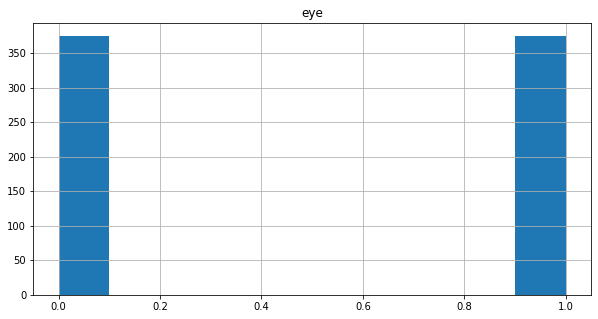

In [12]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level_cat', 'eye']].hist(figsize = (10, 5))
print(train_df['level_cat'])

In [13]:

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [14]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level_cat",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        valid_df,
        x_col="path",
        y_col="level_cat",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 750 validated image filenames belonging to 5 classes.
Found 2310 validated image filenames belonging to 5 classes.


In [15]:
batch_size = 48

# train_gen = flow_from_dataframe(core_idg, train_df, 
#                              path_col = 'path',
#                             y_col = 'level_cat')

# valid_gen = flow_from_dataframe(valid_idg, valid_df, 
#                              path_col = 'path',
#                             y_col = 'level_cat') # we can use much larger batches for evaluation

# Validation Set
We do not perform augmentation at all on these images

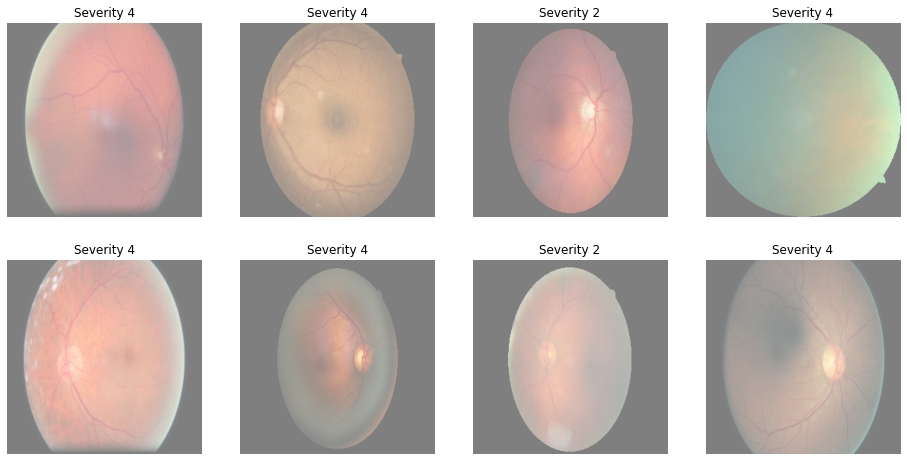

In [16]:
t_x, t_y = next(x_test)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

# Training Set
These are augmented and a real mess

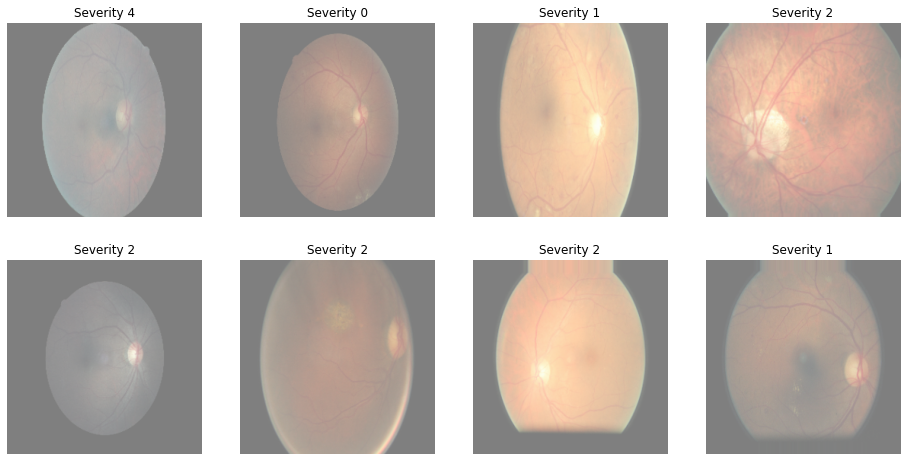

In [17]:
t_x, t_y = next(x_train)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

# Attention Model
The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP.
It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.

In [18]:
from keras.applications.vgg16 import VGG16 as PTModel
# from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
# from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
# in_lay = Input(t_x.shape[1:])
# base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
# base_pretrained_model.trainable = False
# # pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
# pt_depth = base_pretrained_model.layers[0].compute_output_shape(in_lay)

in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]

pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 8, 8, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 512)   2048        ['vgg16[1][0]']                  
 alization)                                                                                       
                             

In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [20]:
retina_model.fit_generator(x_train, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = x_test, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 25, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

<ipython-input-20-add9c1b2568e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  retina_model.fit_generator(x_train,


Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 1.5829 - categorical_accuracy: 0.2706 - top_2_accuracy: 0.4762
Epoch 1: val_loss improved from inf to 1.21053, saving model to retina_weights.best.hdf5
15/15 [==============================] - 273s 18s/step - loss: 1.5829 - categorical_accuracy: 0.2706 - top_2_accuracy: 0.4762 - val_loss: 1.2105 - val_categorical_accuracy: 0.6966 - val_top_2_accuracy: 0.8678 - lr: 0.0010
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 1.5095 - categorical_accuracy: 0.3052 - top_2_accuracy: 0.5476
Epoch 2: val_loss did not improve from 1.21053
15/15 [==============================] - 245s 17s/step - loss: 1.5095 - categorical_accuracy: 0.3052 - top_2_accuracy: 0.5476 - val_loss: 1.2252 - val_categorical_accuracy: 0.6921 - val_top_2_accuracy: 0.8678 - lr: 0.0010
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 1.4827 - categorical_accuracy: 0.3355 - top_2_accuracy: 0.5563
Epoch 3: val_loss did not i

In [21]:
# load the best version of the model
retina_model.load_weights(weight_path)
retina_model.save('full_retina_model.h5')

In [24]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = test_datagen.flow_from_dataframe(
        valid_df,
        x_col="path",
        y_col="level_cat"
)
# valid_gen = test_datagen.flow_from_dataframe(valid_idg, valid_df, 
#                              path_col = 'path',
#                             y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

Found 2310 validated image filenames belonging to 5 classes.


<ipython-input-24-ea0b166e18f6>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)),


  0%|          | 0/47 [00:00<?, ?it/s]

# Show Attention
Did our attention model learn anything useful?

In [25]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

# Evaluate the results
Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. We then visualize spec

In [35]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print(pred_Y_cat.shape)
print(test_Y_cat.shape)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

71/71 [==============================] - 15s 207ms/step
(2256,)
(2256,)
Accuracy on Test Data: 0.47%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       779
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00       248
           3       0.00      0.00      0.00       140
           4       0.47      1.00      0.64      1061

    accuracy                           0.47      2256
   macro avg       0.09      0.20      0.13      2256
weighted avg       0.22      0.47      0.30      2256



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


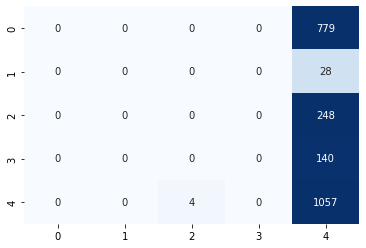

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

# ROC Curve for healthy vs sick
Here we make an ROC curve for healthy (```severity == 0```) and sick (```severity>0```) to see how well the model works at just identifying the disease

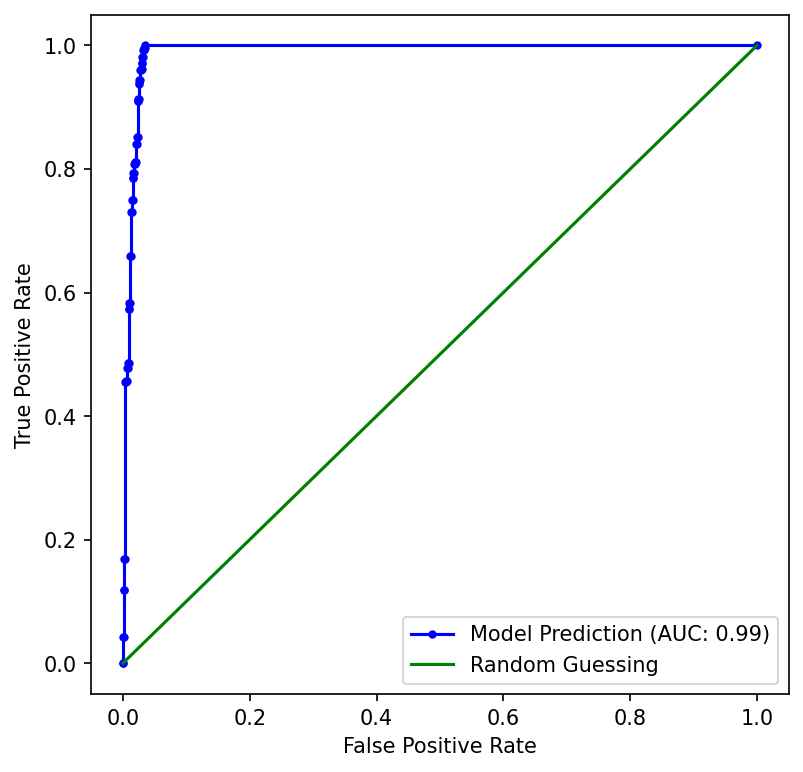

In [37]:

from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

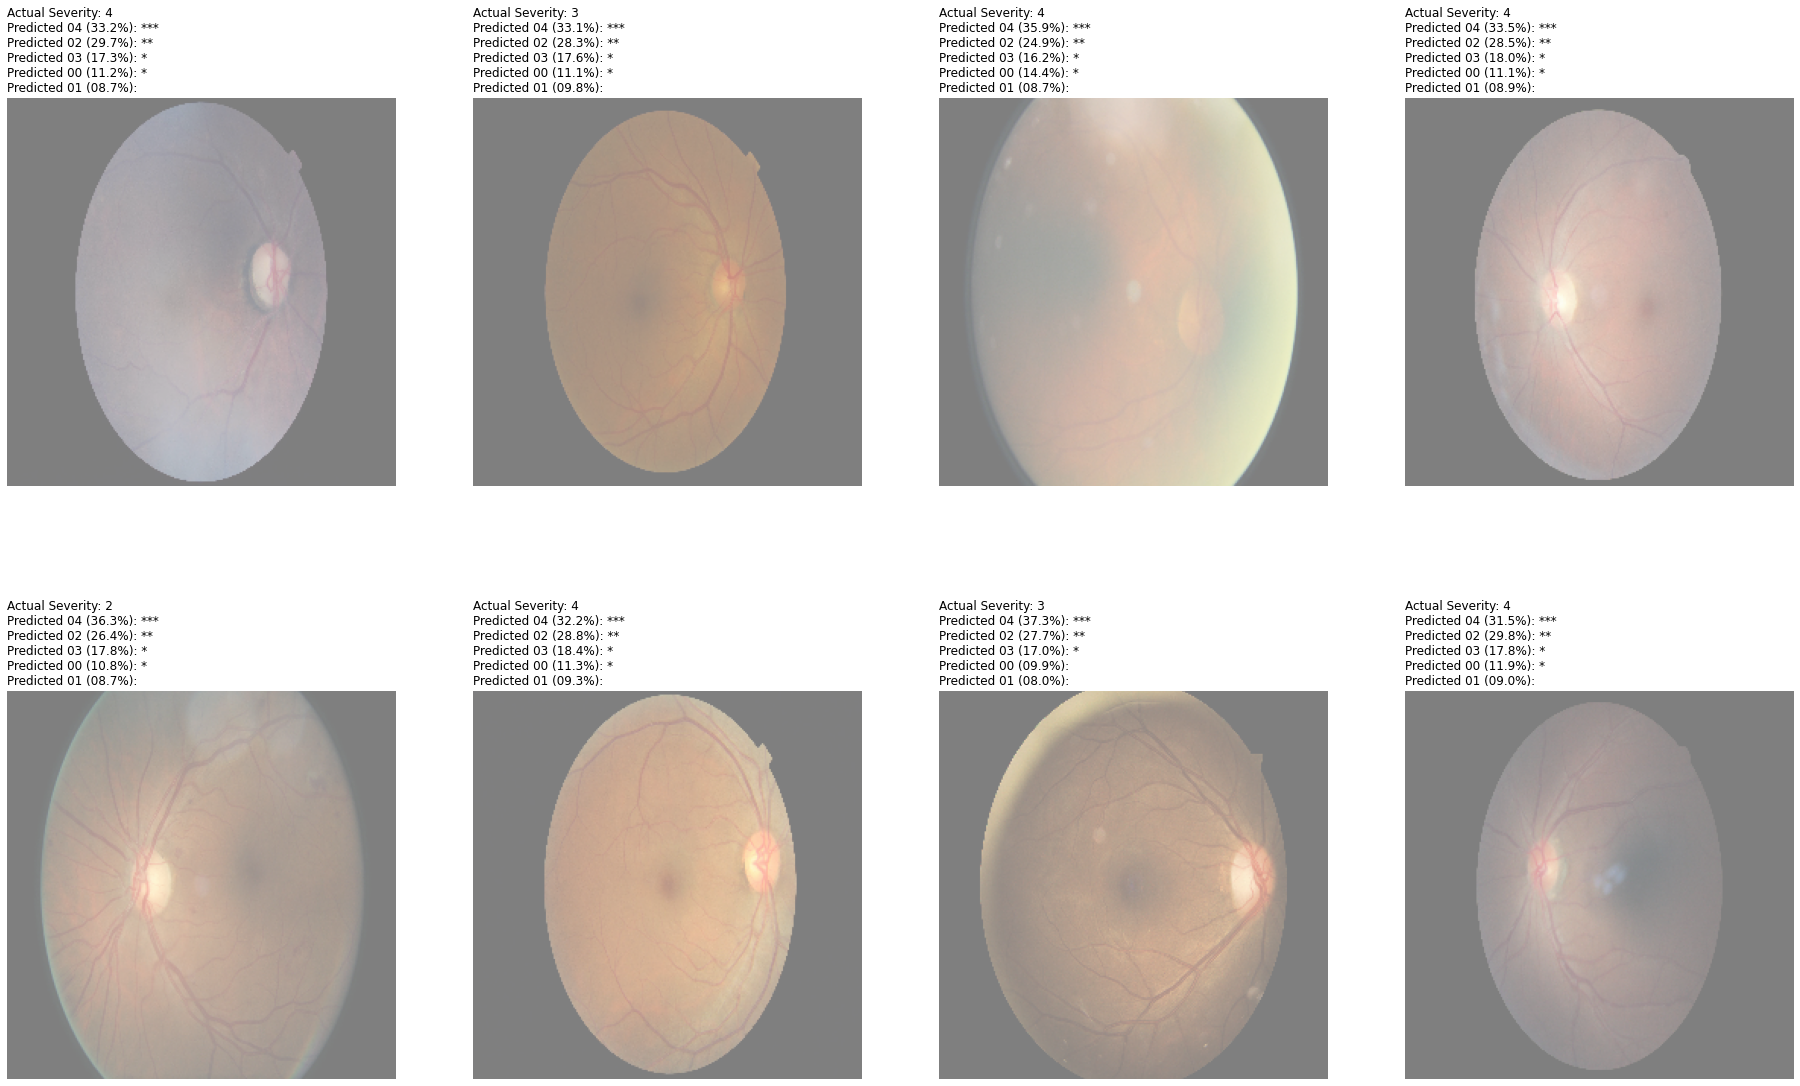

In [38]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)